<a href="https://colab.research.google.com/github/mou58/deep_learning/blob/main/tensorflow/unet2d/ResNet50/cnn_resnet50_onehot_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

## Implement the model

In [ ]:
def conv_block(input, filters:int, kernel_size:tuple=(1,1), strides:tuple=(1,1), 
               padding:str='valid', bn_axis:int=3, activation:str=None):
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(input)
    x = BatchNormalization(axis=bn_axis)(x)
    
    if activation is not None:
        x = Activation(activation)(x)
    
    return x

def resnet_block(input, filters:list, kernel_size:tuple=(3,3), strides:tuple=(1,1), convolutional:bool=False):
    
    x_shortcut = input
    
    x = conv_block(input, filters[0], (1,1), strides, 'valid', 3, 'relu')
    x = conv_block(x, filters[1], kernel_size, (1,1), 'same', 3, 'relu')    
    x = conv_block(x, filters[2], (1,1), (1,1), 'valid', 3, None) 
    
    if convolutional: x_shortcut = conv_block(input, filters[2], (1,1), strides, 'valid', 3, None)
        
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def resnet50(input_shape, n_classes, aug=None):
    
    input = Input(input_shape)

    # Stage 0: zero-padding
    if aug is not None: # with augmentation
      x = aug(input)
      x = ZeroPadding2D((3, 3))(x) 
    else: x = ZeroPadding2D((3, 3))(input) # without augmentation
        
    # Stage 1
    x = conv_block(x, 64, (7,7), (2,2), 'valid', 3, 'relu')    
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    
    # Stage 2
    x = resnet_block(x, [64,64,256], (3,3), (1,1), True)
    x = resnet_block(x, [64,64,256], (3,3), (1,1), False)
    x = resnet_block(x, [64,64,256], (3,3), (1,1), False)
    
    # Stage 3
    x = resnet_block(x, [128,128,512], (3,3), (2,2), True)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    
    # Stage 4
    x = resnet_block(x, [256,256,1024], (3,3), (2,2), True)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    
    # Stage 5
    x = resnet_block(x, [512,512,2048], (3,3), (2,2), True)
    x = resnet_block(x, [512,512,2048], (3,3), (1,1), False) 
    x = resnet_block(x, [512,512,2048], (3,3), (1,1), False) 
    
    # Stage 6: Average pooling
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax', name='fc')(x)

    # Create model
    model = Model(inputs=input, outputs=x, name='ResNet50')

    return model


## Prepare dataset

In [ ]:
# Download CIFAR-10 dataset
(x_, y_), (x_test, y_test) = datasets.cifar10.load_data()

In [ ]:
# Split dataset
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=0.10, random_state=42)

In [ ]:
y_train.shape

(45000, 1)

In [ ]:
# Convert target to 1D
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

In [ ]:
y_train.shape

(45000,)

In [ ]:
# Print shapes
print('Shape of training dataset:', x_train.shape)
print('Shape of validation dataset:', x_val.shape)
print('Shape of test dataset:', x_test.shape)

Shape of training dataset: (45000, 32, 32, 3)
Shape of validation dataset: (5000, 32, 32, 3)
Shape of test dataset: (10000, 32, 32, 3)


In [ ]:
# Normalize the data
x_train = x_train/255.
x_val = x_val/255.
x_test = x_test/255.

In [ ]:
# Class names
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n_classes = len(class_names)

print("No. of classes: ", n_classes)

No. of classes:  10


## Visualize samples

Text(0.5, 1.0, 'frog')

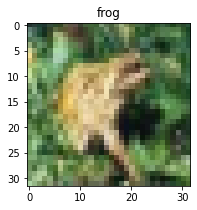

In [ ]:
idx = int(np.random.randint(low=0, high=len(x_train), size=1)) # randomly choose an integer

plt.figure(figsize=(3,3))
plt.imshow(np.squeeze(x_train[idx]))
plt.title(class_names[y_train[idx]])

## Convert to onehot

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

## Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      # layers.RandomZoom(0.2),
    ]
  )

## Build model

In [ ]:
model_name = 'resnet50'

In [ ]:
model = resnet50(input_shape=x_train.shape[1:], n_classes=n_classes, aug=data_augmentation)  

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 38, 38, 3)   0           ['sequential_1[0][0]']           
 D)                                                                                               
                                                                                                  
 conv2d_159 (Conv2D)            (None, 16, 16, 64)   9472        ['zero_padding2d_3[0][0]']

## Compile model

In [ ]:
loss = 'categorical_crossentropy'

metrics = ['accuracy']

model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-3), metrics=metrics)

checkpoint_loc = '/content/drive/MyDrive/CSC 559/checkpoints/' + model_name
log_path = "/content/drive/MyDrive/CSC 559/logs/"

# Create checkpoint directory if does not exist
if not os.path.exists(checkpoint_loc): os.makedirs(checkpoint_loc)
if not os.path.exists(log_path): os.makedirs(log_path)

checkpoint_path = os.path.join(checkpoint_loc, 'best_model.h5')

checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1),
    
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=10,
                      min_lr=0.00001,
                      verbose=1,
                      mode='auto'),
    
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                      monitor = 'val_loss',
                      verbose = 1,
                      save_best_only=True,
                      save_weights_only=True,
                      ),
    tf.keras.callbacks.CSVLogger(os.path.join(log_path, model_name + '.csv'), separator=',', append=True),
]


In [ ]:
# Uncomment to load the model
# model = resnet50(input_shape=x_train.shape[1:], n_classes=n_classes)  
# model.load_weights(checkpoint_loc + '//' + 'best_model.h5')
# model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-5), metrics=metrics)

## Train model

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=256,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=callbacks,
                    shuffle = True,  
                    )

Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 2.1273 - accuracy: 0.2923
Epoch 1: val_loss improved from inf to 2.75431, saving model to /content/drive/MyDrive/CSC 559/checkpoints/resnet50/best_model.h5
176/176 [==============================] - 288s 2s/step - loss: 2.1273 - accuracy: 0.2923 - val_loss: 2.7543 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 2/50
 46/176 [======>.......................] - ETA: 3:31 - loss: 1.8658 - accuracy: 0.3482

176/176 [==============================] - ETA: 0s - loss: 1.9272 - accuracy: 0.3287
Epoch 2: val_loss did not improve from 2.75431
176/176 [==============================] - 287s 2s/step - loss: 1.9272 - accuracy: 0.3287 - val_loss: 4.6048 - val_accuracy: 0.1464 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - ETA: 0s - loss: 1.7714 - accuracy: 0.3767
Epoch 3: val_loss improved from 2.75431 to 2.06783, saving model to /content/drive/MyDrive/CSC 559/checkpoints/resnet50/best_model.h5
176/176 [==============================] - 287s 2s/step - loss: 1.7714 - accuracy: 0.3767 - val_loss: 2.0678 - val_accuracy: 0.2922 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - ETA: 0s - loss: 1.6848 - accuracy: 0.4108
Epoch 4: val_loss improved from 2.06783 to 1.72150, saving model to /content/drive/MyDrive/CSC 559/checkpoints/resnet50/best_model.h5
176/176 [==============================] - 287s 2s/step - loss: 1.6848 - accuracy: 0.4108 - val_loss: 1.7215 - val_acc

In [ ]:
# Save model
model.save("/content/drive/MyDrive/CSC 559/checkpoints/last_model")

## Plot loss and accuracy curve

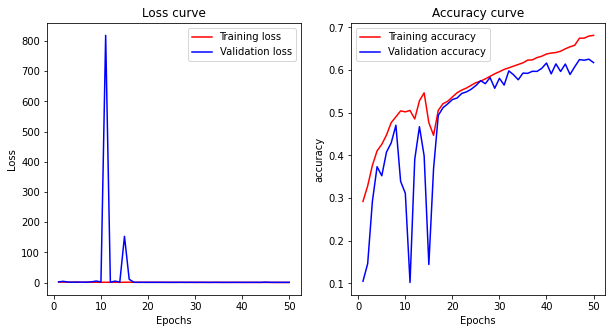

In [ ]:
save_fig_dir = "/content/drive/MyDrive/CSC 559/plots/"
if not os.path.exists(save_fig_dir): os.makedirs(save_fig_dir)

fig, ax = plt.subplots(1,2, figsize=(10,5))
history_dict = history.history

# Plot loss curve
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
ax[0].plot(epochs, loss_values, "r", label="Training loss")
ax[0].plot(epochs, val_loss_values, "b", label="Validation loss")
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot accuracy curve
acc_train = history_dict["accuracy"]
acc_val = history_dict["val_accuracy"]
ax[1].plot(epochs, acc_train, "r", label="Training accuracy")
ax[1].plot(epochs, acc_val, "b", label="Validation accuracy")
ax[1].set_title("Accuracy curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

fig.savefig(os.path.join(save_fig_dir, model_name + '_onehot' + '.png'))    

## Load model

In [ ]:
# Uncomment to load the model
# model = resnet50(input_shape=x_train.shape[1:], n_classes=n_classes)  
# model.load_weights(checkpoint_loc + '//' + 'best_model.h5') 
# model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-5), metrics=metrics)

# model = load_model("last_model")

In [ ]:
# tf.config.run_functions_eagerly(True)
score = model.evaluate(x_test, y_test_onehot, verbose=1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

  1/313 [..............................] - ETA: 25s - loss: 0.5793 - accuracy: 0.7812

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 24s 75ms/step - loss: 1.2278 - accuracy: 0.6189
Test loss: 1.2277989387512207
Test accuracy: 0.6189000010490417


In [ ]:
# y_pred_raw = model.predict(x_test)
# y_pred= [np.argmax(element) for element in y_pred_raw]

# print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
# Prediction
prediction = model.predict(x_test)

313/313 [==============================] - 19s 62ms/step


In [ ]:
pred = np.argmax(prediction, axis = 1)

In [ ]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test, pred)
print(conf_mat)

[[772  27  29   8  14   5   8  15  69  53]
 [ 18 715   4   8   3   6  19  12  28 187]
 [121  22 388  37 128  52 124  74  27  27]
 [ 30  26  36 322  73 167 160  86  29  71]
 [ 43   6  80  18 542  25 144 115  11  16]
 [ 26  18  27 127  54 499  73 101  26  49]
 [  6   9  27  27  49  22 804  16   7  33]
 [ 38  12  11  34  56  56  43 678  11  61]
 [115  55  10   9   8  15   6   3 717  62]
 [ 44 121   5   9   5   5  17  27  15 752]]


In [ ]:
# Pandas view of confusion matrix
df = pd.DataFrame(conf_mat, index = class_names, columns = class_names)
print(df)

            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
airplane         772          27    29    8    14    5     8     15    69   
automobile        18         715     4    8     3    6    19     12    28   
bird             121          22   388   37   128   52   124     74    27   
cat               30          26    36  322    73  167   160     86    29   
deer              43           6    80   18   542   25   144    115    11   
dog               26          18    27  127    54  499    73    101    26   
frog               6           9    27   27    49   22   804     16     7   
horse             38          12    11   34    56   56    43    678    11   
ship             115          55    10    9     8   15     6      3   717   
truck             44         121     5    9     5    5    17     27    15   

            truck  
airplane       53  
automobile    187  
bird           27  
cat            71  
deer           16  
dog            49  
frog        

In [ ]:
import scipy.io as sio
sio.savemat("/content/drive/MyDrive/CSC 559/result.mat", {'y':y_test, 'p': pred}, do_compression=True)

